# Task description
```
mask, digits = predict_image(img)

# example
digits = [
    np.array([[-1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, -1, -1,  8,  9,  4, -1, -1, -1],
              [-1, -1, -1,  6, -1,  1, -1, -1, -1],
              [-1,  6,  5,  1, -1,  9,  7,  8, -1],
              [-1,  1, -1, -1, -1, -1, -1,  3, -1],
              [-1,  3,  9,  4, -1,  5,  6,  1, -1],
              [-1, -1, -1,  8, -1,  2, -1, -1, -1],
              [-1, -1, -1,  9,  1,  3, -1, -1, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1]]),
]
```


## What should we take into account
- folded pages
- some cells of the puzzle may be hidden
- May be the case when to edges are not in the image
- more than 1 puzzle in image
- some cells of sudoku can be gray-colored
- when warp puzzle, consider its orientation

In [63]:
import joblib
from pathlib import Path
import glob
import re

import numpy as np
from numpy import logical_and as land
from numpy import logical_not as lnot
from skimage.feature import canny
from skimage.transform import rescale, ProjectiveTransform, warp
from skimage.morphology import dilation, disk
import cv2 as cv
import matplotlib.pyplot as plt

import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
from torchvision import transforms

from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
import imutils

trans = transforms.ToTensor()

## Global variables and functions

In [2]:
PROJ_PATH = Path('/home/dendenmushi/projects/Intro2CV_course/Homework_2')
IMAGES_PATH = PROJ_PATH/'images'
TRAIN_PATH = PROJ_PATH/'train'
TRAIN_IMG_NAMES = glob.glob(str(TRAIN_PATH/'*.jpg'))
TRAIN_IMG_NAMES.sort(key = lambda x: re.findall('\d+', x)[-1])

SCALE = 0.33

# Find puzzle boundaries

In [3]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [267]:
def find_puzzle_mask( image: np.ndarray, debug: bool = False ):
    area_thr = 700*700
    rect_ratio_thresh = 0.7
    puzzle_areas_ratio_min = 0.7

    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    blurred = cv.GaussianBlur(gray, (7, 7), 5)
    thresh = cv.adaptiveThreshold(blurred, 255,
        cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2)
    thresh = cv.bitwise_not(thresh)
    open_kernel = np.ones((3,3))
    open_iters = 2
    
    thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, open_kernel, iterations=open_iters, borderType=cv.BORDER_CONSTANT)
    # To eliminate several contours in thick sudoku borders
    dilate_kernel = np.ones((3,3))
    dilate_iters = 5
    # thresh = cv.morphologyEx(thresh, cv.MORPH_DILATE, dilate_kernel, iterations=dilate_iters, borderType=cv.BORDER_CONSTANT)

    if debug:
        cv.namedWindow("Puzzle_Thresh", cv.WINDOW_NORMAL)
        cv.resizeWindow("Puzzle_Thresh", 600, 400)
        cv.imshow("Puzzle_Thresh", thresh)
    cnts, hierarchy = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL,
        cv.CHAIN_APPROX_SIMPLE)
    
    cnts, hierarchy = zip(*((c, h) for c,h in zip(cnts,hierarchy[0]) if cv.contourArea(c) > area_thr))
    hierarchy = [hierarchy]

    if debug:
        det_cnts_img = image.copy()
        hulls = [cv.convexHull(c) for c in cnts]
        det_cnts_img = cv.drawContours(det_cnts_img, hulls, -1, color=(0,150,255), thickness=3)
        det_cnts_img = cv.drawContours(det_cnts_img, cnts, -1, color=(0,255,255), thickness=3)
        cv.namedWindow("detected_contours", cv.WINDOW_NORMAL)
        cv.resizeWindow("detected_contours", 600, 400)		
        cv.imshow("detected_contours", det_cnts_img)

    # cnts_imu = imutils.grab_contours(cnts)
    cnts_imu = sorted(cnts, key=cv.contourArea, reverse=True)
    puzzle_cnts = []
    puzzle_mask = None
    
    max_puzzle_area = cv.contourArea(cnts_imu[0])
    cnts_imu = list(filter(lambda c: cv.contourArea(c)/max_puzzle_area > puzzle_areas_ratio_min, cnts_imu) )

    for c in cnts_imu:
        peri = cv.arcLength(c, True)
        hull = cv.convexHull(c)
        approx = cv.approxPolyDP(hull, 0.02 * peri, closed=True)
        if len(approx) > 8:
            continue	
        
        rect = cv.minAreaRect(c)
        center, dims, angle = rect
        box = cv.boxPoints(rect)
        box = np.int0(box)
        if min(dims)/max(dims) < rect_ratio_thresh:
            continue

        puzzle_cnts.append(hull)

    if debug:
        if len(puzzle_cnts) > 0:
            output = image.copy()
            cv.namedWindow("puzzle_outline", cv.WINDOW_NORMAL)
            cv.resizeWindow("puzzle_outline", 600, 400)
            cv.drawContours(output, puzzle_cnts, -1, (0, 255, 0), 2)
            cv.imshow("puzzle_outline", output)
        else:
            print('I have not found puzzle contour!')

    if len(puzzle_cnts) == 0 :
        return puzzle_mask, puzzle_cnts

    puzzle_mask = np.zeros_like(thresh)
    puzzle_mask = cv.fillPoly(puzzle_mask, puzzle_cnts, 255)
        

    # puzzle = four_point_transform(image, puzzle_cnts.reshape(4, 2))
    # warped = four_point_transform(gray, puzzle_cnts.reshape(4, 2))

    if debug:
        cv.namedWindow("puzzle_mask", cv.WINDOW_NORMAL)
        cv.resizeWindow("puzzle_mask", 600, 400)
        cv.imshow("puzzle_mask", puzzle_mask/255)
    # return a 2-tuple of puzzle in both RGB and grayscale
    return puzzle_mask/255, puzzle_cnts


def warp_puzzles_denis( puzzle_contours, img_orig ):
    warped_imgs = []
    
    for c in puzzle_contours:
        rect = cv.minAreaRect(c)

        box = cv.boxPoints(rect)
        box = np.int0(box)
        perimeter = cv.arcLength(c, True) 
        epsilon = 0.01 * perimeter
        approx = cv.approxPolyDP(c,epsilon,True)
        if approx.shape[0] == 4:
            box = approx.reshape(4,-1)
        center, dims, angle = rect
        # dst = np.array([[0, 0],[max(dims) - 1, 0],[max(dims) - 1, max(dims) - 1],[0, maxHeight - 1]], dtype = "float32")
        # M = cv.getPerspectiveTransform(rect, dst)
        # warped = cv.warpPerspective(img_orig, M, (maxWidth, maxHeight))
        # warped_imgs.append(warped)
        
    return warped_imgs


def warp_puzzles( puzzle_contours, img_orig):

    warped_imgs = []
    
    for c in puzzle_contours:
        rect = cv.minAreaRect(c)

        box = cv.boxPoints(rect)
        box = np.int0(box)
        perimeter = cv.arcLength(c, True) 
        epsilon = 0.01 * perimeter
        approx = cv.approxPolyDP(c,epsilon,True)
        if approx.shape[0] == 4:
            box = approx.reshape(4,-1)
        rect = np.zeros((4, 2), dtype = "float32")
        s = box.sum(axis = 1)
        rect[0] = box[np.argmin(s)]
        rect[2] = box[np.argmax(s)]
        diff = np.diff(box, axis = 1)
        rect[1] = box[np.argmin(diff)]
        rect[3] = box[np.argmax(diff)]
        (tl, tr, br, bl) = rect
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))
        dst = np.array([[0, 0],[maxWidth - 1, 0],[maxWidth - 1, maxHeight - 1],[0, maxHeight - 1]], dtype = "float32")
        M = cv.getPerspectiveTransform(rect, dst)
        warped = cv.warpPerspective(img_orig, M, (maxWidth, maxHeight))
        warped_imgs.append(warped)
        
    return warped_imgs

def find_puzzle( img, debug=False ):
    puzzle_mask, puzzle_cnts = find_puzzle_mask(img, debug)
    return puzzle_mask, warp_puzzles( puzzle_cnts, img)


def find_cells(img, debug=False):
    """
    Find the cells of a sudoku grid
    """
    img_area = img.shape[0] * img.shape[1]

    contours, _ = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    # Array containing the cropped cell image and its position in the grid
    cells = []
    for c in contours:
        area = cv.contourArea(c)

        # Approximate the contour in order to determine whether the contour is a quadrilateral
        peri = cv.arcLength(c, True)
        approx = cv.approxPolyDP(c, 0.017 * peri, True)

        # We are looking for a contour of a specific area in relation to the grid size
        # and that is roughly quadrilateral
        # We filter for areas that are too small or too large in relation to the whole image
        if area / img_area > 0.0001 and area / img_area < 0.02 and len(approx) == 4:
            # Using masking, we crop the cell into its own 28 by 28 pixel image
            mask = np.zeros_like(img)
            cv.drawContours(mask, [c], -1, 255, -1)

            (y, x) = np.where(mask == 255)

            (top_y, top_x) = (np.min(y), np.min(x))
            (bottom_y, bottom_x) = (np.max(y), np.max(x))
            cell = img[top_y : bottom_y + 1, top_x : bottom_x + 1]

            cell = cell.copy()
            cell = cv.resize(cell, (28, 28))

            # We also find the centroid of the cell in relation
            # to the grid
            M = cv.moments(c)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])

            cells.append(({"img": cell, "pos": (cX, cY)}))
   
    return cells


def find_cells_manual( warped_gray, debug=False ):
    assert len(warped_gray.shape) == 2

    h,w = warped_gray.shape
    h_cell = int(h / 9)
    w_cell = int(w / 9)
    win = 10
    print(h_cell, w_cell)
    cells = []
    for i in range(9):
        cells.append([])
        for j in range(9):
            begin = [h_cell*i, w_cell*j]
            end = [h_cell*(i+1), w_cell*(j+1)]
            cell_img = warped_gray[begin[0]+win:end[0]-win, begin[1]+win:end[1]-win].copy()
            cells[i].append(cell_img)

    return cells


def find_cells_digits(cells):
    model = LeNet5()
    model = model.to(device)
    model.load_state_dict(torch.load('mnist_net.pt', map_location=torch.device('cpu')))
    pred_thresh = 22
    empty_thr = 140
    non_empty_area_thr = 0.12
    
    digit_cells = np.full((9,9), -1)
    pred_vals = np.zeros((9,9))
    for i in range(9):
        for j in range(9):
            input = cv.bitwise_not(cells[i][j])
            h,w = input.shape
            area = len(np.where(cv.threshold(input, empty_thr, 255, cv.THRESH_BINARY)[1] > empty_thr)[0])/(h*w)
            # area = (cv.adaptiveThreshold(input, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2).sum()/255)/(h*w)
            input = cv.resize(input, (28,28))
            input = cv.normalize(input, input, 0, 255, cv.NORM_MINMAX)
            
            input = trans(input)
            pred = model.forward(input[np.newaxis,...])
            maximum = pred.max()
            dig = np.where(pred == maximum)[1][0]
            if area > non_empty_area_thr :
                digit_cells[i,j] = dig
            # pred_vals[i,j] = maximum
            pred_vals[i,j] = str(round(area, 2))
    print(pred_vals.mean())
    return digit_cells, pred_vals

In [6]:
PROJ_PATH / 'amogus'

PosixPath('/home/dendenmushi/projects/Intro2CV_course/Homework_2/amogus')

In [7]:
TRAIN_IMG_NAMES

['/home/dendenmushi/projects/Intro2CV_course/Homework_2/train/train_0.jpg',
 '/home/dendenmushi/projects/Intro2CV_course/Homework_2/train/train_1.jpg',
 '/home/dendenmushi/projects/Intro2CV_course/Homework_2/train/train_2.jpg',
 '/home/dendenmushi/projects/Intro2CV_course/Homework_2/train/train_3.jpg',
 '/home/dendenmushi/projects/Intro2CV_course/Homework_2/train/train_4.jpg',
 '/home/dendenmushi/projects/Intro2CV_course/Homework_2/train/train_5.jpg',
 '/home/dendenmushi/projects/Intro2CV_course/Homework_2/train/train_6.jpg',
 '/home/dendenmushi/projects/Intro2CV_course/Homework_2/train/train_7.jpg',
 '/home/dendenmushi/projects/Intro2CV_course/Homework_2/train/train_8.jpg']

In [8]:
img = cv.imread(str(TRAIN_IMG_NAMES[0]))

In [64]:
np.full((3,3), -1)

array([[-1, -1, -1],
       [-1, -1, -1],
       [-1, -1, -1]])

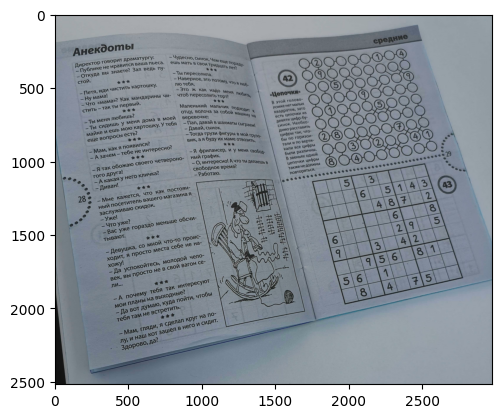

In [9]:
fig, ax = plt.subplots()

ax.imshow(img);

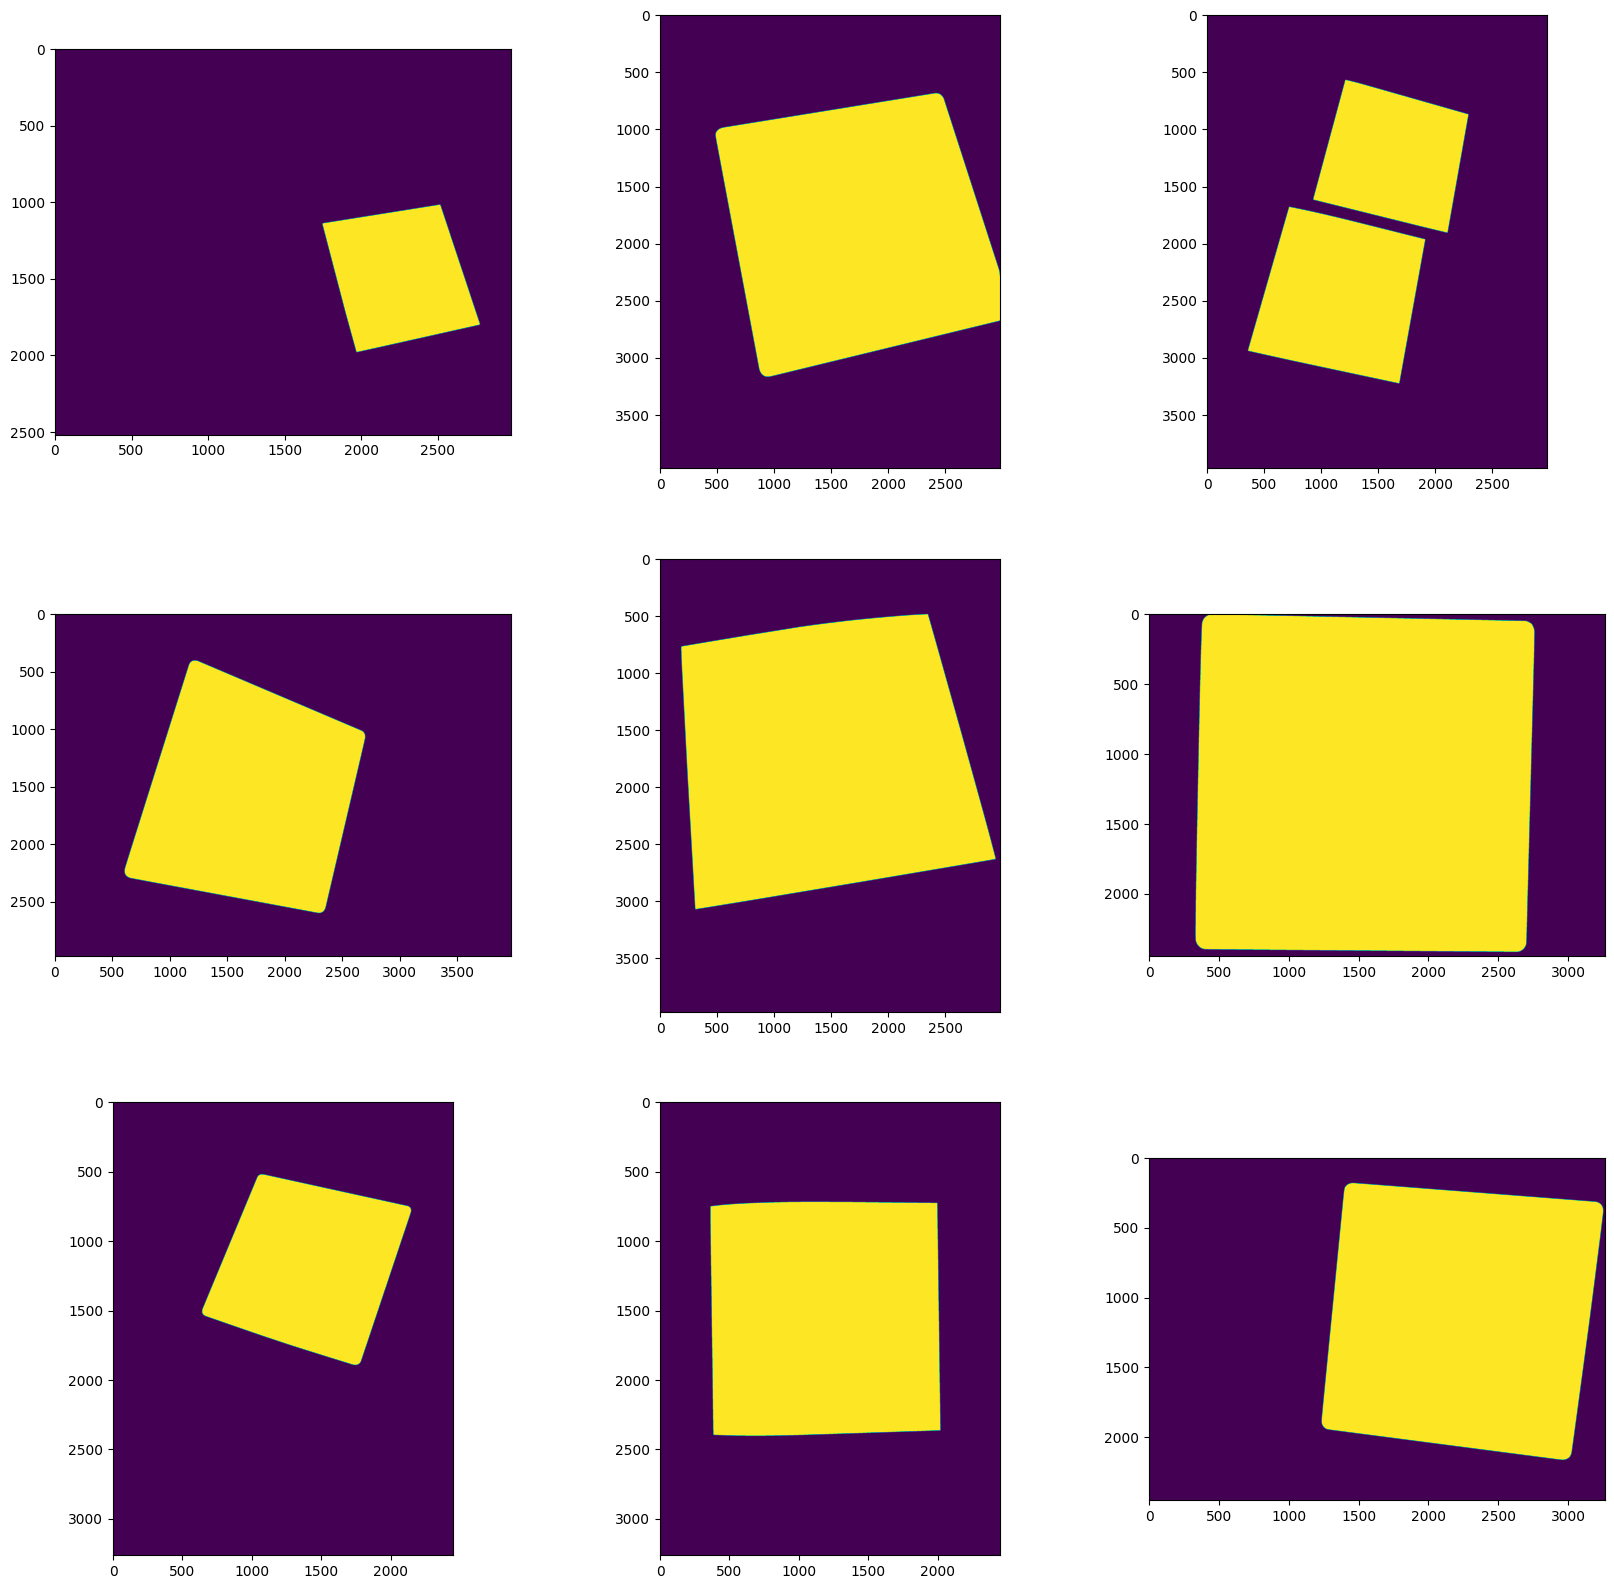

In [10]:
fig,ax = plt.subplots(3,3, figsize=(20,20))
for i, fname in enumerate(TRAIN_IMG_NAMES):
    img = cv.imread(fname)
    puzzle, _ = find_puzzle(img)
    ax[i//3,i%3].imshow(puzzle);

In [270]:
img = cv.imread(str(TRAIN_IMG_NAMES[0]))
puzzle, warped = find_puzzle(img, debug=False)

puzzle_cell = find_cells(cv.cvtColor(warped[0], cv.COLOR_BGR2GRAY))

In [271]:
puzzle_cell

[]

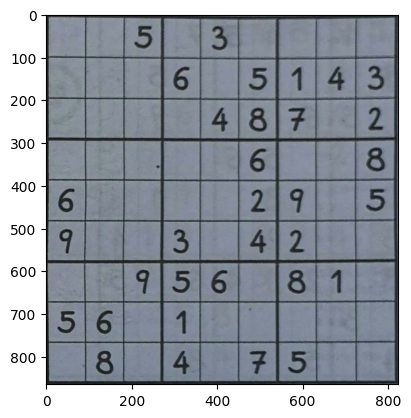

In [272]:
plt.imshow(warped[0]);

In [273]:
puzzle_cells = find_cells_manual(cv.cvtColor(warped[0], cv.COLOR_BGR2GRAY))

96 91


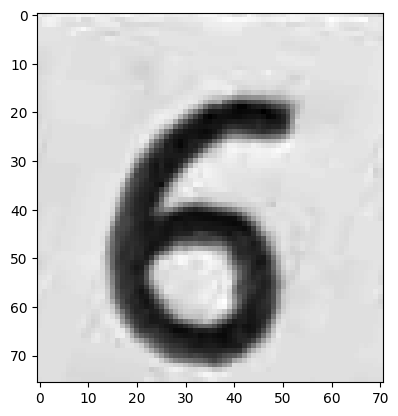

In [274]:
plt.imshow(puzzle_cells[1][3], cmap='gray')

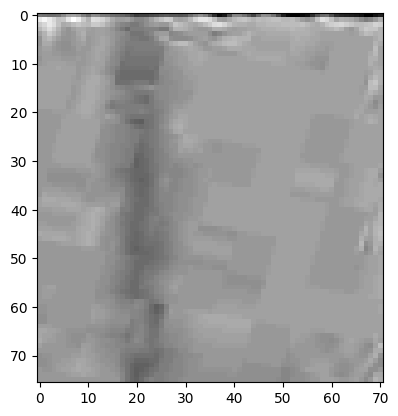

In [275]:
plt.imshow(puzzle_cells[1][4], cmap='gray')

In [276]:
puzzle_cells[2][2].shape

(76, 71)

In [277]:
model = LeNet5()
model = model.to(device)
model.load_state_dict(torch.load('mnist_net.pt', map_location=torch.device('cpu')));

In [278]:
# input = puzzle_cells[4][6][np.newaxis,...]
input = cv.bitwise_not(puzzle_cells[0][0])
input = cv.resize(input, (28,28))
input = cv.normalize(input, input, 0, 255, cv.NORM_MINMAX)
print(input.max(), input.min())

255 0


torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])


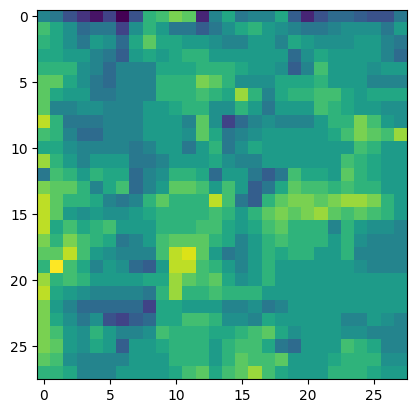

In [279]:
trans = transforms.ToTensor()
input = trans(input)
print(input.shape)
print(input[np.newaxis,...].shape)
plt.imshow(input[0]);

In [280]:
print(input.shape)
pred = model.forward(input[np.newaxis,...])
maximum = pred.max()
print(pred)
print(np.where(pred == maximum)[1][0])

torch.Size([1, 28, 28])
tensor([[  4.5406, -25.4258,  18.6151,   5.8064, -18.3311,  -2.9969,   5.8581,
         -13.6545,  21.6832,  -7.2460]], grad_fn=<AddmmBackward0>)
8


In [281]:
pred

tensor([[  4.5406, -25.4258,  18.6151,   5.8064, -18.3311,  -2.9969,   5.8581,
         -13.6545,  21.6832,  -7.2460]], grad_fn=<AddmmBackward0>)

In [282]:
digit_cells, pred_vals = find_cells_digits(puzzle_cells)

0.08098765432098766


In [283]:
print(digit_cells,'\n', pred_vals)

[[-1 -1  5 -1  3 -1 -1 -1 -1]
 [-1 -1 -1  5 -1  5  1  4  3]
 [-1 -1 -1 -1  4  8  7 -1  2]
 [-1 -1 -1 -1 -1  5 -1 -1  8]
 [ 6 -1 -1 -1 -1  8  9 -1  5]
 [ 9 -1 -1  3 -1  4  8 -1 -1]
 [-1 -1  9  5  5 -1  3  1 -1]
 [ 5  6 -1 -1 -1 -1 -1 -1 -1]
 [-1  8 -1  4 -1  8  5 -1 -1]] 
 [[0.   0.   0.21 0.02 0.22 0.04 0.04 0.02 0.  ]
 [0.   0.   0.   0.21 0.   0.22 0.13 0.19 0.2 ]
 [0.   0.   0.   0.   0.18 0.25 0.18 0.   0.17]
 [0.   0.   0.01 0.   0.01 0.23 0.01 0.   0.27]
 [0.21 0.   0.   0.   0.   0.16 0.17 0.   0.22]
 [0.15 0.   0.   0.18 0.   0.18 0.16 0.   0.  ]
 [0.   0.   0.16 0.21 0.22 0.   0.26 0.13 0.  ]
 [0.2  0.21 0.   0.12 0.   0.   0.   0.   0.  ]
 [0.   0.24 0.   0.18 0.   0.18 0.21 0.   0.  ]]


In [284]:
print(pred_vals[6,0:6])

[0.   0.   0.16 0.21 0.22 0.  ]


In [285]:
aa = np.ones((3,3,3))*255
len(np.where( aa == 255)[0])

27

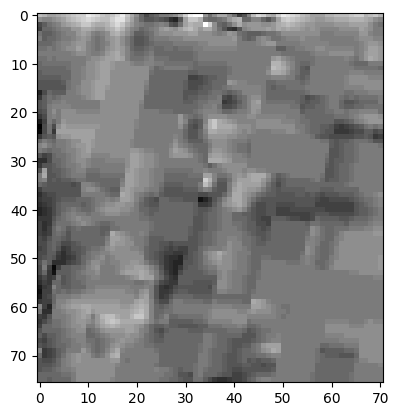

In [286]:
plt.imshow(puzzle_cells[0][0], cmap='gray')

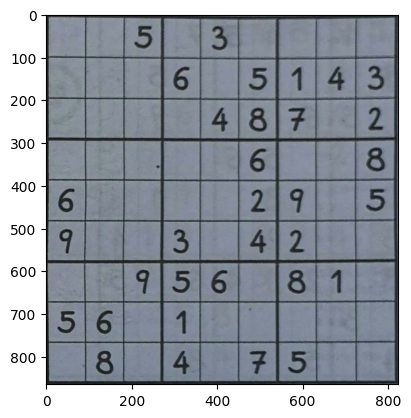

In [287]:
plt.imshow(warped[0]);